In [2]:
# Step 1: Import Libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Layer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [8]:
# Step 2: Load and Preprocess Data
# Create synthetic time series data (a sine wave)
data = np.sin(np.linspace(0, 100, 500))  # 500 time steps
data = data.reshape(-1, 1)

# Normalize the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Create sequences: use 20 time steps to predict the next value
seq_length = 20
X, y = [], []
for i in range(seq_length, len(data_scaled)):
    X.append(data_scaled[i-seq_length:i, 0])
    y.append(data_scaled[i, 0])
X = np.array(X)
y = np.array(y)
# Reshape X to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape, y.shape


((480, 20, 1), (480,))

In [4]:
# Step 3: Define a Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create trainable weights for computing attention scores
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute alignment scores using tanh activation
        score = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        # Normalize scores to get attention weights
        attention_weights = tf.nn.softmax(score, axis=1)
        # Compute the context vector as a weighted sum of inputs
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights



In [5]:
# Step 4: Build the RNN Model with Attention
# Define the input layer with shape (seq_length, 1)
input_seq = Input(shape=(seq_length, 1))
# Add an LSTM layer that outputs the full sequence (return_sequences=True)
lstm_out = LSTM(50, return_sequences=True)(input_seq)
# Apply the custom attention layer
context_vector, attention_weights = AttentionLayer()(lstm_out)
# Add a final Dense layer for regression (linear activation)
output = Dense(1, activation='linear')(context_vector)
# Create the model
model = Model(inputs=input_seq, outputs=output)
model.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 20, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ [(None, 50), (None, 20,     │           2,550 │
│                                      │ 50)]                        │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,001 (50.79 KB)

 Trainable params: 13,001 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Step 5: Compile and Train the Model
model.compile(optimizer='adam', loss='mse')
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)



Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.2785 - val_loss: 0.2168
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2189 - val_loss: 0.1894
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1869 - val_loss: 0.1620
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1485 - val_loss: 0.1114
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0898 - val_loss: 0.0016
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0100 - val_loss: 0.0017
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 8.7725e-04
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.3050e-04 - val_loss: 4.7014e-04
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6789e-04 - val_loss: 2.5190e-04
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.9001e-04 - val_loss: 1.1771e-04
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6961e-05
Test Loss: 4.7023397200973704e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


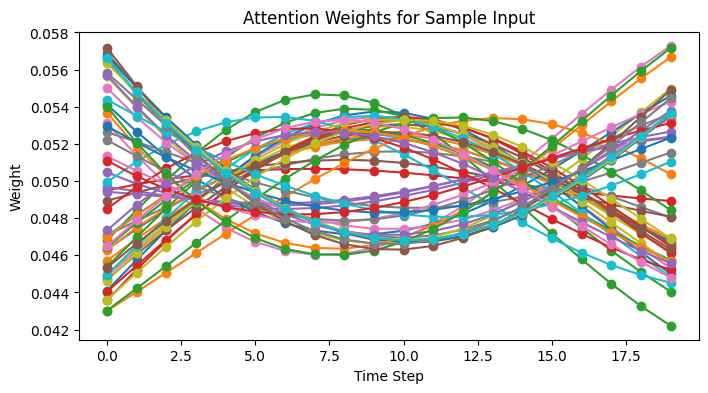

In [7]:
# Step 6: Evaluate and Visualize the Model's Performance
loss = model.evaluate(X, y)
print("Test Loss:", loss)

# Create a model to output the attention weights
attention_model = Model(inputs=model.input, outputs=attention_weights)
# Select a sample input from the dataset
sample_index = 0  # You can change this to another index
sample_input = X[sample_index:sample_index+1]
att_weights = attention_model.predict(sample_input)

# Visualize the attention weights for the sample input
plt.figure(figsize=(8, 4))
plt.plot(att_weights[0], marker='o')
plt.title("Attention Weights for Sample Input")
plt.xlabel("Time Step")
plt.ylabel("Weight")
plt.show()